# Training on 13,231 events from ACTS. Testing on 3308 events from ACTS.

In [ ]:
!nvidia-smi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
import sys
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

### Load in the data.

In [ ]:
%%time
# This is how the ACTS data was cleaned.
# Don't run this cell unless you want to overwrite the current cleaned data.
mapper = {}
for key in range(  30,   35): mapper[key] = 32
for key in range(  70,   75): mapper[key] = 72
for key in range( 115,  120): mapper[key] = 117
for key in range( 170,  175): mapper[key] = 172
for key in range( 255,  270): mapper[key] = 260
for key in range( 355,  370): mapper[key] = 360
for key in range( 495,  510): mapper[key] = 500
for key in range( 655,  670): mapper[key] = 660
for key in range( 815,  830): mapper[key] = 820
for key in range(1010, 1030): mapper[key] = 1020

print("Loading in the frame.")
filepath   = "data/sets/progenitors/ACTS.gz"
events     = utils.list_of_groups(pd.read_csv(filepath), "event_id")
frame      = pd.concat([event for event in events if metrics.number_of_tracks(event) <= 25])
frame["r"] = frame["r"].round().map(mapper)
frame.drop_duplicates(["event_id", "cluster_id", "r"], keep="first", inplace=True)
print("Preparing the frame.")
frame = ext.prepare_frame(frame, n_tracks=25, n_rows=250, n_noise=0)
frame = frame.sample(frac=1)  # Shuffle the set.
print(frame["cluster_id"].max())
print("Saving the frame.")
frame.to_csv("data/sets/ACTS-25T-250R.gz", compression="gzip")

In [3]:
%%time
modelpath = "data/models/ACTS-25T-250R.h5"
filepath  = "data/sets/ACTS--0N-25T-16539E-250R.gz"
frame     = pd.read_csv(filepath)
events    = [event for (_, event) in frame.groupby("event_id", sort=False)]
percent   = 0.8
cutoff    = int(percent * len(events))
train, test = events[:cutoff], events[cutoff:]
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
print("Train takes up {} bytes.".format(sys.getsizeof(train)))
print("Test takes up {} bytes.".format(sys.getsizeof(test)))
if (not utils.is_prepared(train[0])) or (not utils.is_prepared(test[0])):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py") 

Train is list of 13232 events.
Test is list of 3308 events.
105920
26528
CPU times: user 6.33 s, sys: 264 ms, total: 6.59 s
Wall time: 6.59 s


In [4]:
order = ["phi", "r", "z"]

### Get an idea for how the tracks are distributed among the events.

In [ ]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

In [ ]:
dist = metrics.distributions(pd.concat(test))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

### Show an example of the data.

Train 5496
Number of Hits: 110
Number of Tracks: 21


<IPython.core.display.Javascript object>


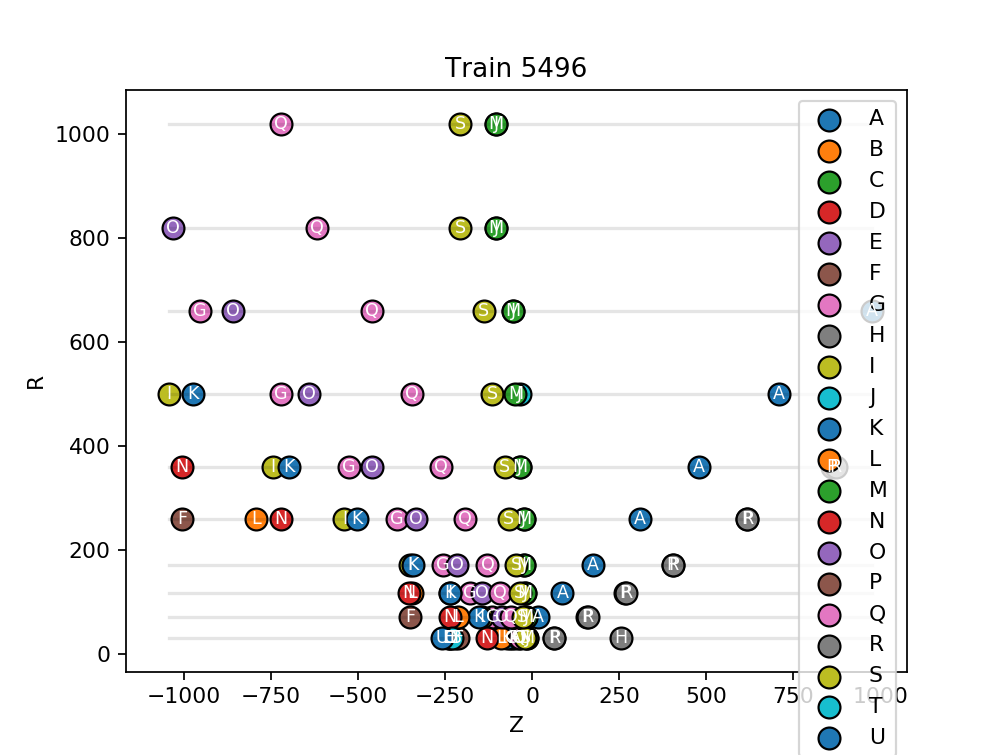

<IPython.core.display.Javascript object>


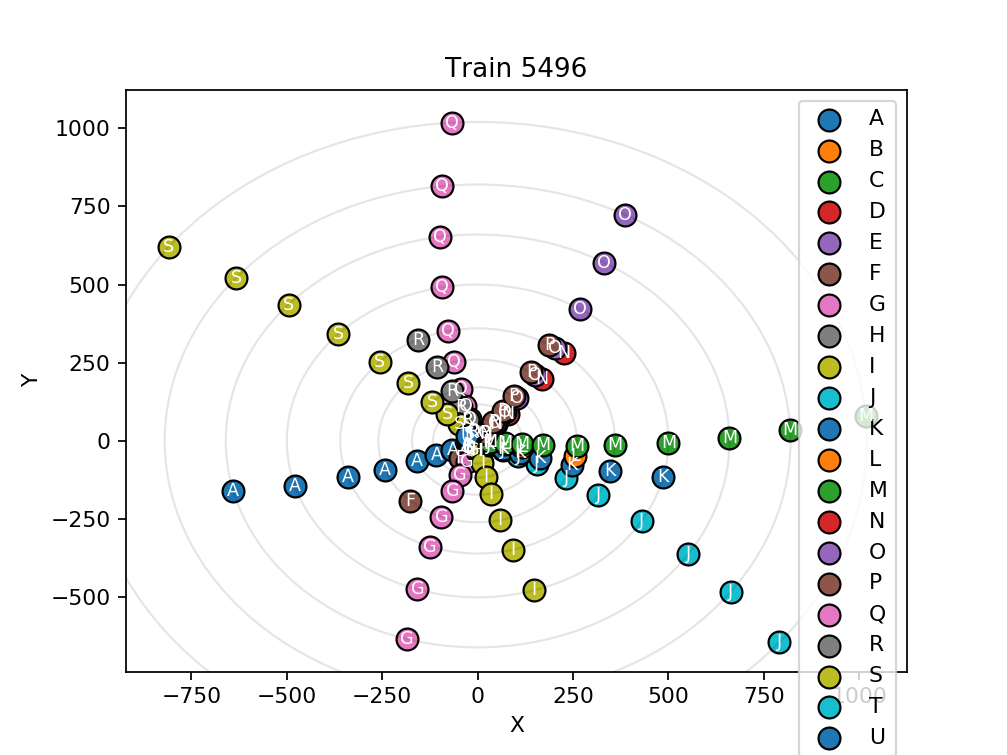

In [21]:
n = np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="zr", title="Train {}".format(n))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [22]:
visuals.display(train[n], order)

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.898323,660.0,975.0000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-2.851287,500.0,709.0000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.811777,360.0,479.0000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.781980,260.0,309.0000,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.757337,172.0,175.1410,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.741701,117.0,86.9872,1,,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.729171,72.0,16.2125,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.717483,32.0,-49.4956,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.518870,32.0,-220.8130,,1,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.482323,32.0,-235.1370,,,1,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [5]:
input_shape  = (250, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 250, 256)          399360    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 250, 256)          787968    
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 250, 256)          787968    
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 256)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 250, 27)           6939      
Total para

### Fit the model.

In [6]:
%%time
# 128 + 32
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=10, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)]))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


Epoch 1/128
132/132 [==============================] - 212s - loss: 1.1726 - acc: 0.6962 - val_loss: 0.7029 - val_acc: 0.7344
Epoch 2/128
132/132 [==============================] - 201s - loss: 0.7342 - acc: 0.7313 - val_loss: 0.6280 - val_acc: 0.7485
Epoch 3/128
132/132 [==============================] - 202s - loss: 0.6703 - acc: 0.7471 - val_loss: 0.5843 - val_acc: 0.7761
Epoch 4/128
132/132 [==============================] - 201s - loss: 0.6329 - acc: 0.7574 - val_loss: 0.5432 - val_acc: 0.7932
Epoch 5/128
132/132 [==============================] - 202s - loss: 0.6029 - acc: 0.7644 - val_loss: 0.5101 - val_acc: 0.7906
Epoch 6/128
132/132 [==============================] - 202s - loss: 0.5746 - acc: 0.7747 - val_loss: 0.5084 - val_acc: 0.7918
Epoch 7/128
132/132 [==============================] - 203s - loss: 0.5448 - acc: 0.7835 - val_loss: 0.6284 - val_acc: 0.7466
Epoch 8/128
132/132 [==============================] - 201s - loss: 0.4990 - acc: 0.8029 - val_loss: 0.4278 - val_acc:

132/132 [==============================] - 203s - loss: 0.0523 - acc: 0.9853 - val_loss: 0.0369 - val_acc: 0.9904
Epoch 65/128
132/132 [==============================] - 203s - loss: 0.0529 - acc: 0.9852 - val_loss: 0.0361 - val_acc: 0.9906
Epoch 66/128
132/132 [==============================] - 203s - loss: 0.0535 - acc: 0.9850 - val_loss: 0.0363 - val_acc: 0.9906
Epoch 67/128
132/132 [==============================] - 201s - loss: 0.0522 - acc: 0.9854 - val_loss: 0.0365 - val_acc: 0.9906
Epoch 68/128
132/132 [==============================] - 202s - loss: 0.0510 - acc: 0.9856 - val_loss: 0.0365 - val_acc: 0.9906
Epoch 69/128
132/132 [==============================] - 202s - loss: 0.0522 - acc: 0.9854 - val_loss: 0.0362 - val_acc: 0.9906
Epoch 70/128
132/132 [==============================] - 201s - loss: 0.0495 - acc: 0.9858 - val_loss: 0.0366 - val_acc: 0.9906
Epoch 71/128
131/132 [============================>.] - ETA: 1s - loss: 0.0515 - acc: 0.9856
Epoch 00070: reducing learning 

### Display information about the model after fitting it.

In [7]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 97.4272878223841%
Percent of tracks assigned correctly: 93.82896115368024%
Percent of events with the correct number of tracks: 95.49576783555018%
CPU times: user 1min 19s, sys: 104 ms, total: 1min 19s
Wall time: 1min 19s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 95.45454545454545%
Percent of tracks assigned correctly: 83.33333333333334%


<IPython.core.display.Javascript object>


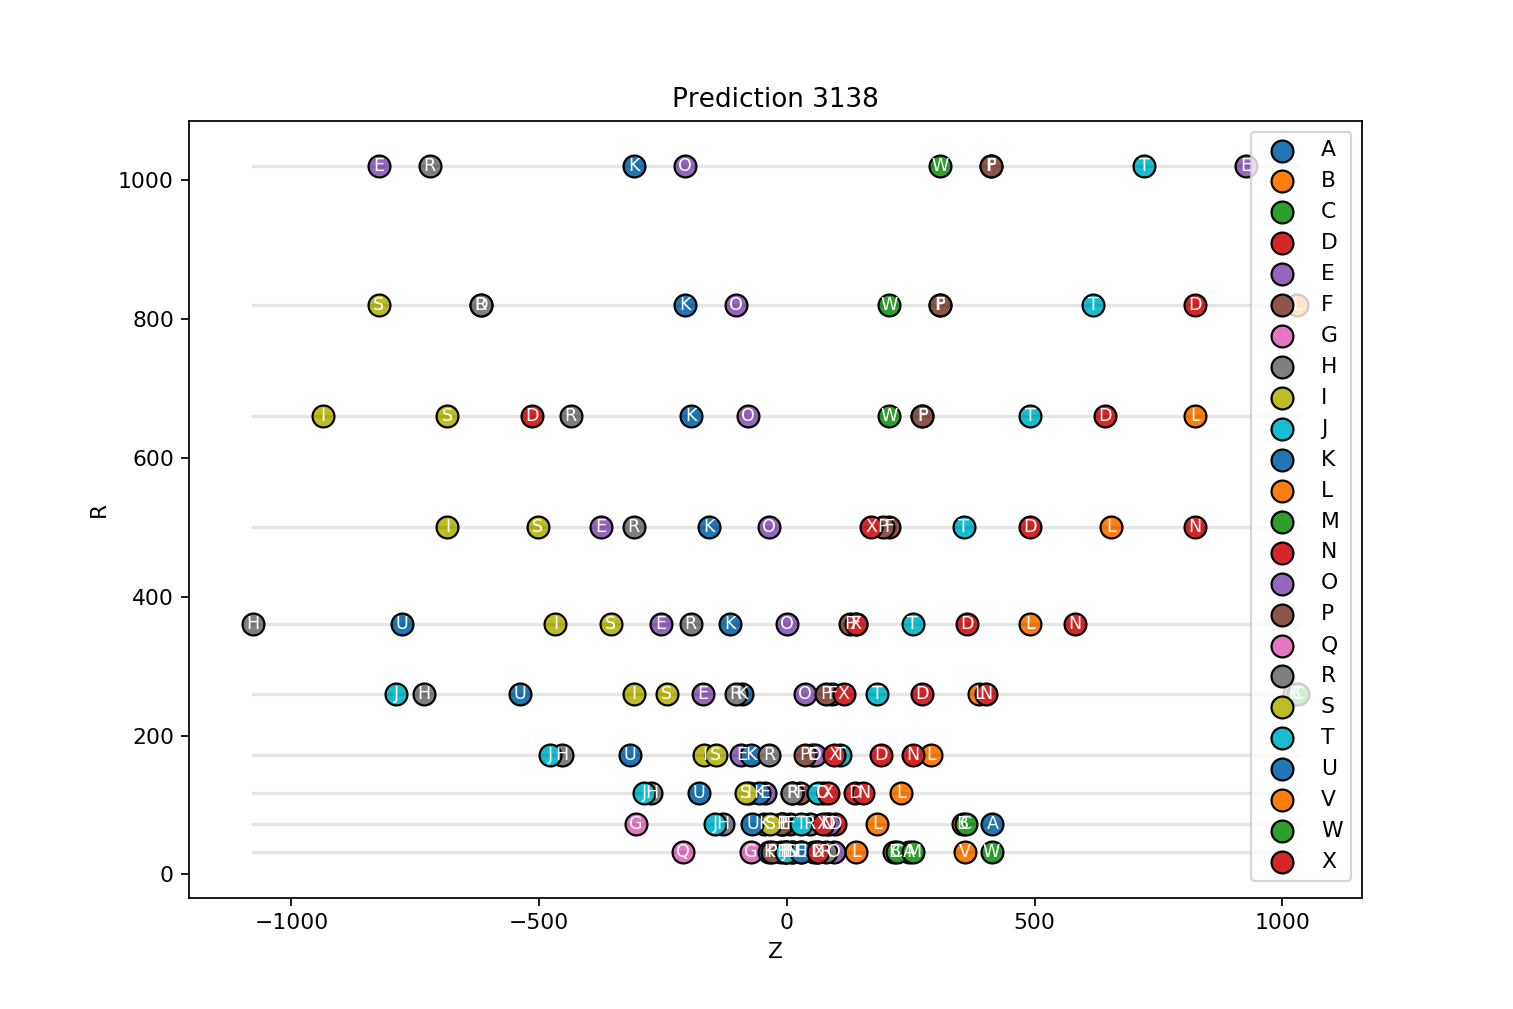

<IPython.core.display.Javascript object>


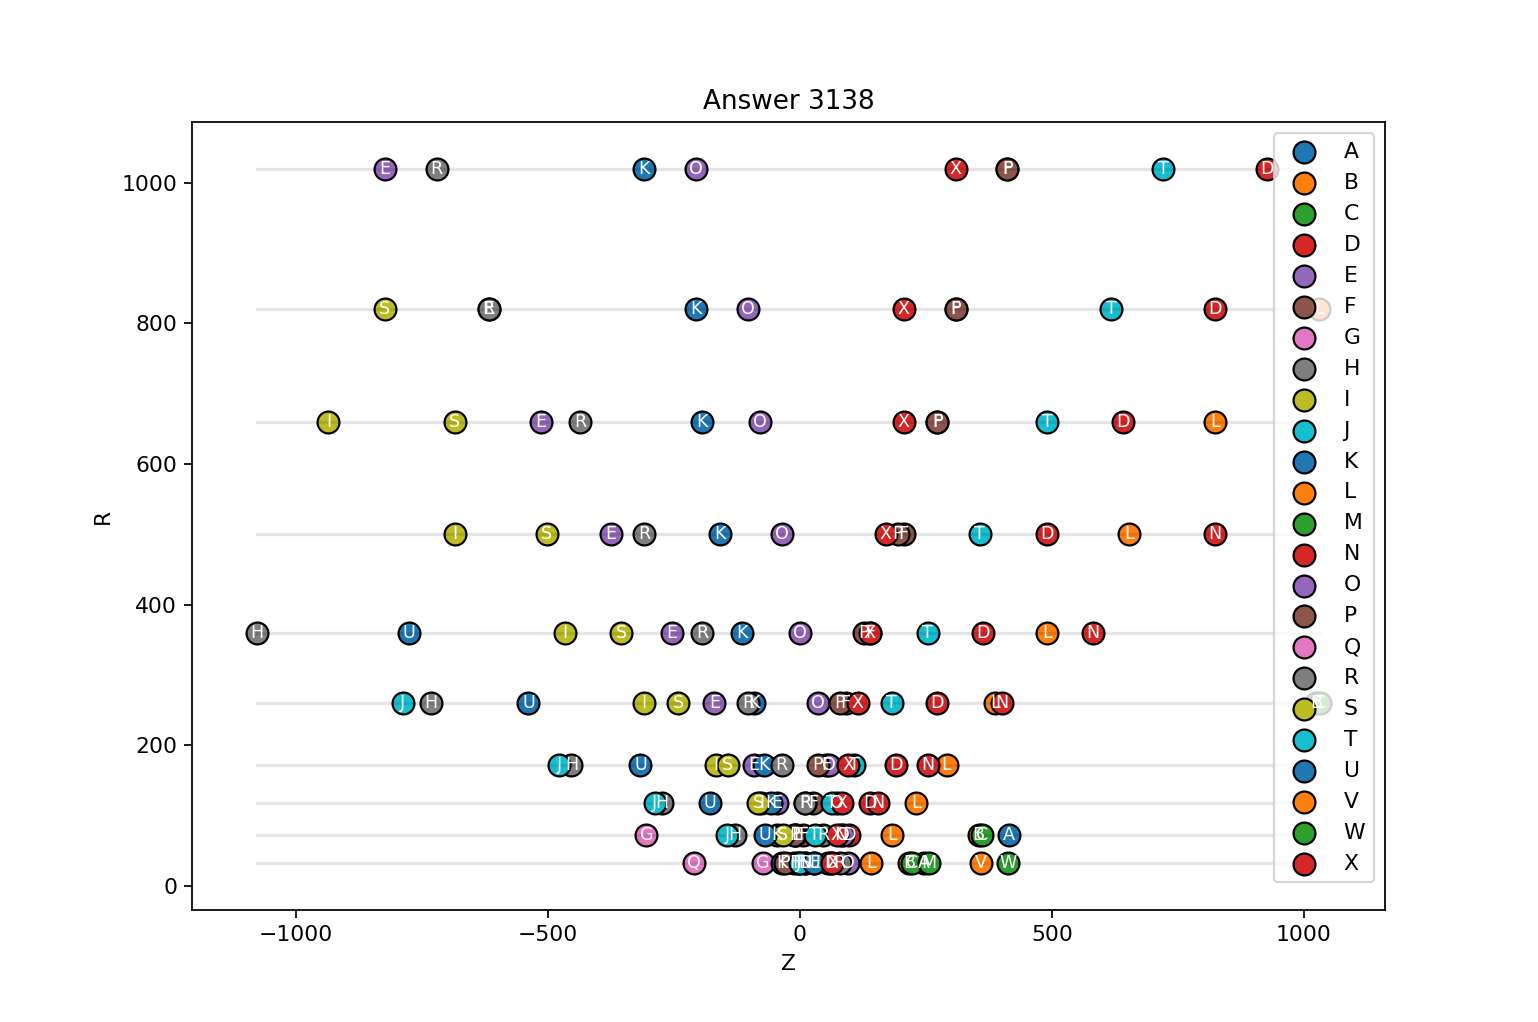

<IPython.core.display.Javascript object>


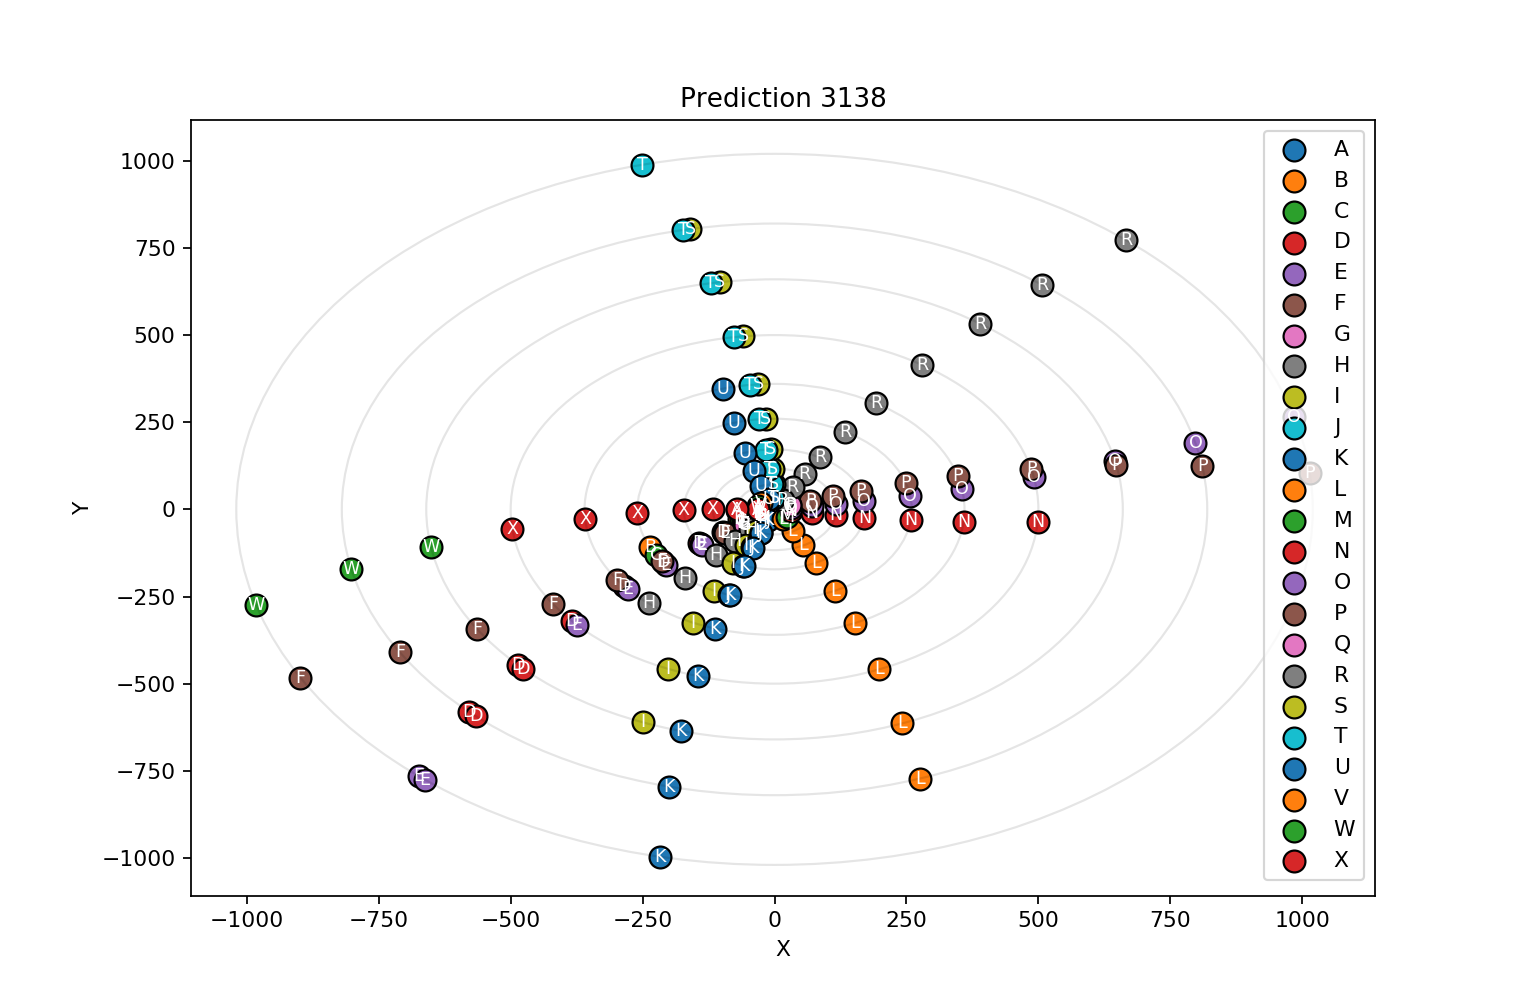

<IPython.core.display.Javascript object>


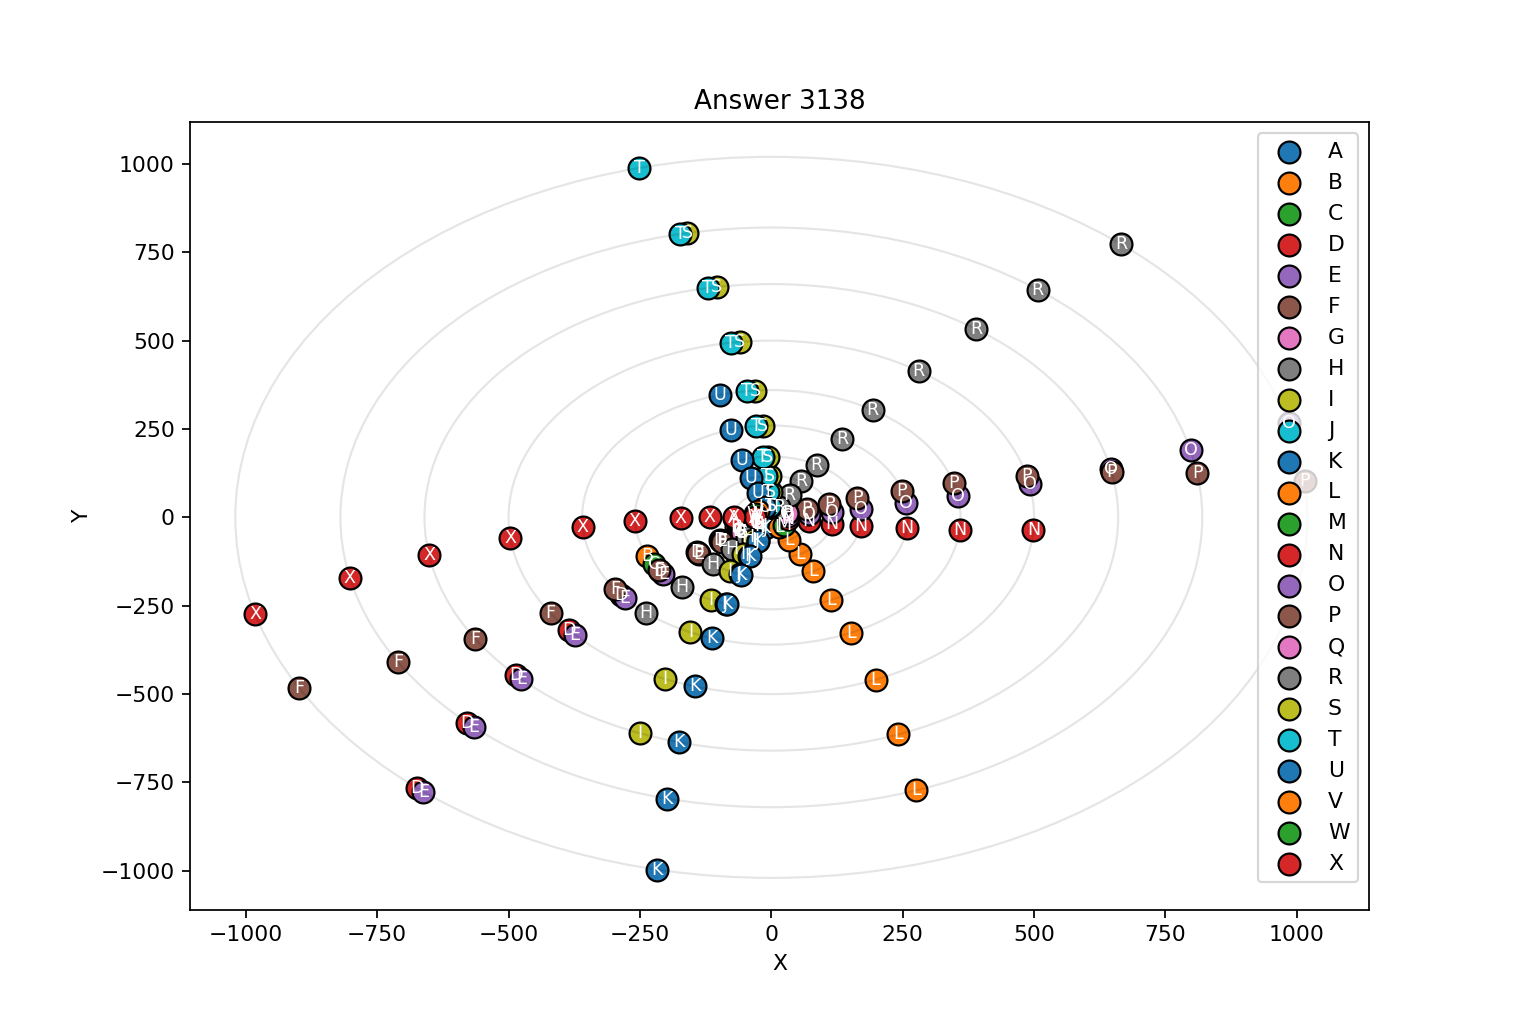

In [15]:
n  = 3138  # np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="zr", title="Answer {}".format(n))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Prediction {}".format(n))
_ = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer {}".format(n))

In [12]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.260902,500.0,1066.0000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
1,-2.225908,360.0,757.0000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.203529,260.0,563.0000,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.182101,172.0,368.6870,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.168828,117.0,251.4690,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.158443,72.0,158.9410,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
6,-2.149023,32.0,77.7209,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.020018,32.0,29.7687,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.008586,72.0,54.2256,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
9,-1.996469,117.0,81.8444,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>


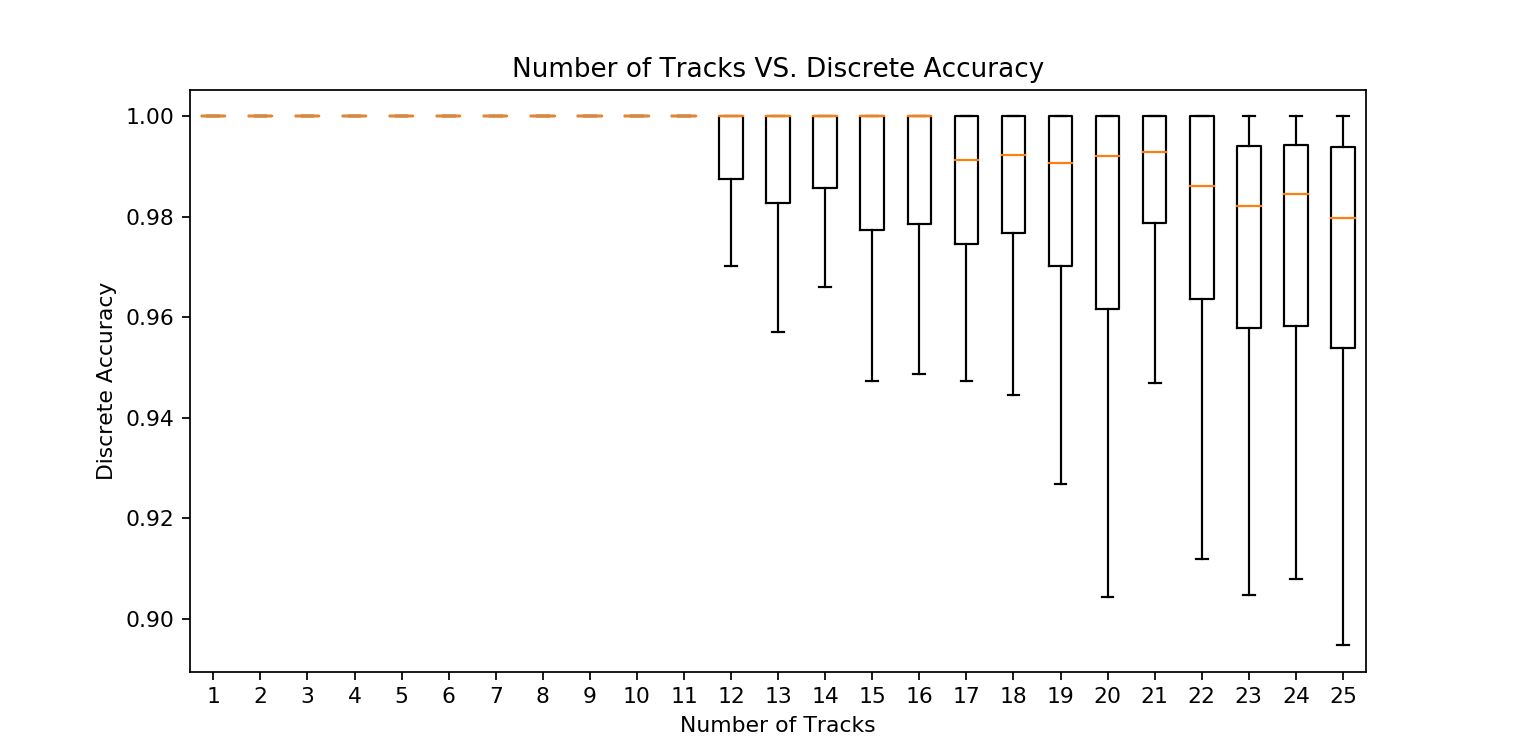

CPU times: user 26.8 s, sys: 12 ms, total: 26.8 s
Wall time: 26.8 s


In [13]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "Number of Tracks VS. Discrete Accuracy", "Number of Tracks", "Discrete Accuracy", xticks=list(r))